/tmp/ipykernel_659683/282512491.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist["plot_time"] = jitter_times


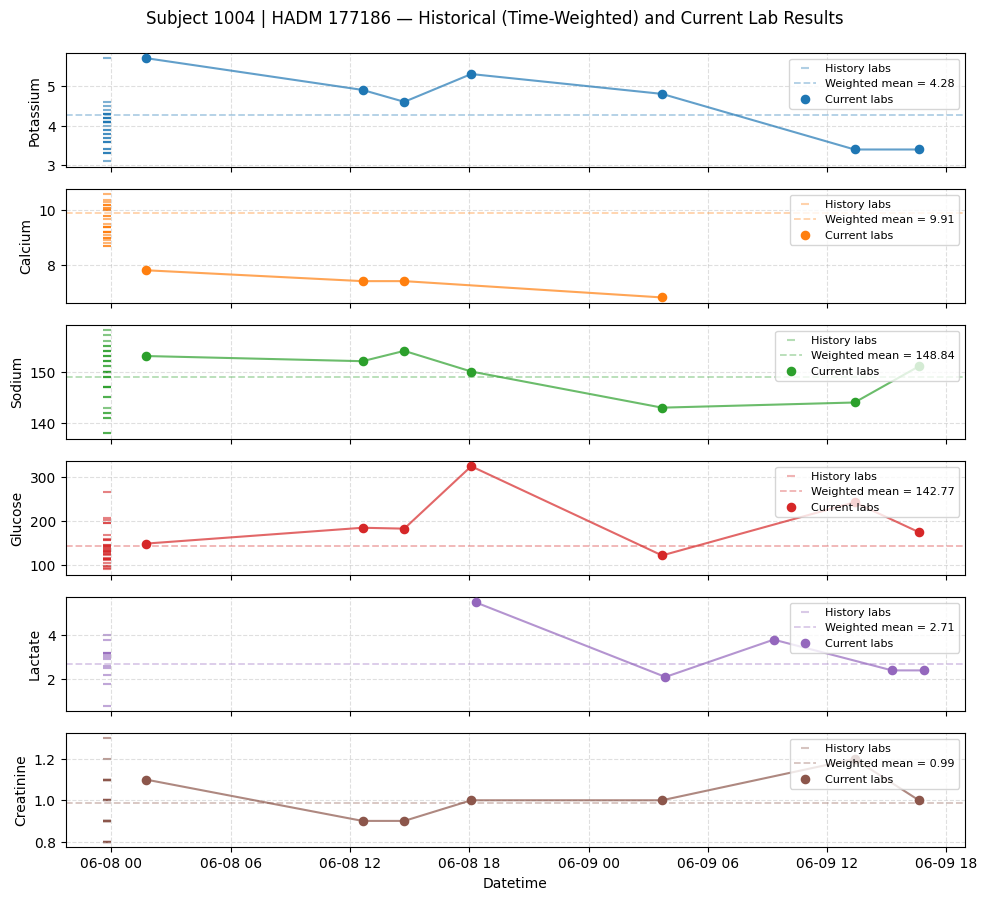

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import matplotlib.colors as mcolors

def time_weighted_mean(times, values, decay=3.0):
    """
    Compute a time-weighted mean using exponential decay.
    More recent times get larger weights.

    Parameters
    ----------
    times : pandas.Series of datetime64
    values : array-like of floats
    decay : float
        Higher decay -> faster dropoff of older values.
        Typically between 2 and 5 gives smooth weighting.

    Returns
    -------
    float : weighted mean value
    """
    if len(times) == 0:
        return np.nan
    t = (times.max() - times).dt.total_seconds().to_numpy()
    if t.max() == 0:
        weights = np.ones_like(t)
    else:
        weights = np.exp(-decay * t / t.max())  # exponential weighting
    return np.average(values, weights=weights)


def plot_labs_overlay_history(df_hist, df_curr, subject_id, hadm_id,
                              hist_frac=0.05, jitter_frac=0.02, decay=3.0):
    """
    Plot lab results for one subject:
      - Historical labs (before this admission) shown slightly before the current timeline
      - Time-weighted historical mean (recent labs weigh more)
      - No interpolation of unmeasured values
      - All subplots share the same x-axis
    """
    # --- Select data ---
    curr = df_curr[(df_curr["SUBJECT_ID"] == subject_id)
                   & (df_curr["HADM_ID"] == hadm_id)]
    if curr.empty:
        print("No current admission data found for this subject/HADM.")
        return

    start_time = curr["CHARTTIME"].min()
    hist = df_hist[(df_hist["SUBJECT_ID"] == subject_id)
                   & (df_hist["CHARTTIME"] < start_time)]

    # --- Determine shared x-axis range ---
    tmin, tmax = curr["CHARTTIME"].min(), curr["CHARTTIME"].max()
    total_range = (tmax - tmin).total_seconds()
    hist_start_time = tmin - pd.Timedelta(seconds=total_range * hist_frac)

    # --- Compute shared jitter times for history points ---
    if len(hist) > 0:
        jitter_offsets = np.linspace(-1, 0, len(hist)) * total_range * hist_frac * jitter_frac
        jitter_times = [hist_start_time + pd.Timedelta(seconds=float(o))
                        for o in jitter_offsets]
        hist["plot_time"] = jitter_times
    else:
        hist["plot_time"] = pd.NaT

    # --- Lab setup ---
    lab_cols = [
        "Potassium", "Calcium", "Sodium", "Glucose",
        "Lactate", "Creatinine", "Triglycerides", "Cholesterol_LDL"
    ]
    labs_present = [col for col in lab_cols
                    if curr[col].notna().any() or hist[col].notna().any()]
    n = len(labs_present)
    fig, axs = plt.subplots(n, 1, figsize=(10, 1.5 * n), sharex=True)
    if n == 1:
        axs = [axs]

    color_cycle = list(plt.cm.tab10.colors)

    # --- Plot each lab ---
    for ax, col, base_color in zip(axs, labs_present, color_cycle):
        sub_curr = curr[curr[col].notna()].copy()
        sub_hist = hist[hist[col].notna()].copy()

        if sub_curr.empty and sub_hist.empty:
            continue

        hist_color = mcolors.to_rgba(base_color, alpha=0.35)

        # --- Historical labs ---
        if not sub_hist.empty:
            ax.scatter(sub_hist["plot_time"], sub_hist[col], marker="_", 
                       color=hist_color, s=35, label="History labs")

            # Compute time-weighted mean
            hist_mean = time_weighted_mean(sub_hist["CHARTTIME"], sub_hist[col], decay=decay)
            ax.axhline(hist_mean, color=hist_color, linestyle="--", linewidth=1.3,
                       label=f"Weighted mean = {hist_mean:.2f}")

        # --- Current admission labs (no interpolation) ---
        if not sub_curr.empty:
            sub_curr = sub_curr.groupby("CHARTTIME", as_index=False)[col].mean().sort_values("CHARTTIME")
            ax.scatter(sub_curr["CHARTTIME"], sub_curr[col],
                       color=base_color, s=35, label="Current labs", zorder=3)
            if len(sub_curr) > 1:
                ax.plot(sub_curr["CHARTTIME"], sub_curr[col],
                        color=base_color, alpha=0.7, linewidth=1.5)

        ax.set_ylabel(col)
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend(loc="upper right", fontsize=8)

    axs[-1].set_xlabel("Datetime")
    fig.suptitle(f"Subject {subject_id} | HADM {hadm_id} — Historical (Time-Weighted) and Current Lab Results",
                 y=0.995)
    plt.tight_layout()
    plt.show()


# Load data
df_hist = pd.read_csv(
    "/labs/hulab/mxwang/data/MIMIC_iii/to_yuhao/mimic_lab_waveform_history.csv",
    parse_dates=["CHARTTIME"]
)
df_curr = pd.read_csv(
    "/labs/hulab/mxwang/data/MIMIC_iii/to_yuhao/mimic_lab_waveform_overlap.csv",
    parse_dates=["CHARTTIME"]
)

# Example usage
plot_labs_overlay_history(df_hist, df_curr, subject_id=1004, hadm_id=177186, hist_frac=0.05)


15
Loaded 107_174162_0_PLETH40_II120_II500_2673.npz
Segments: 2673
PLETH40 length: 1200, II120 length: 3600, II500 length: 15000


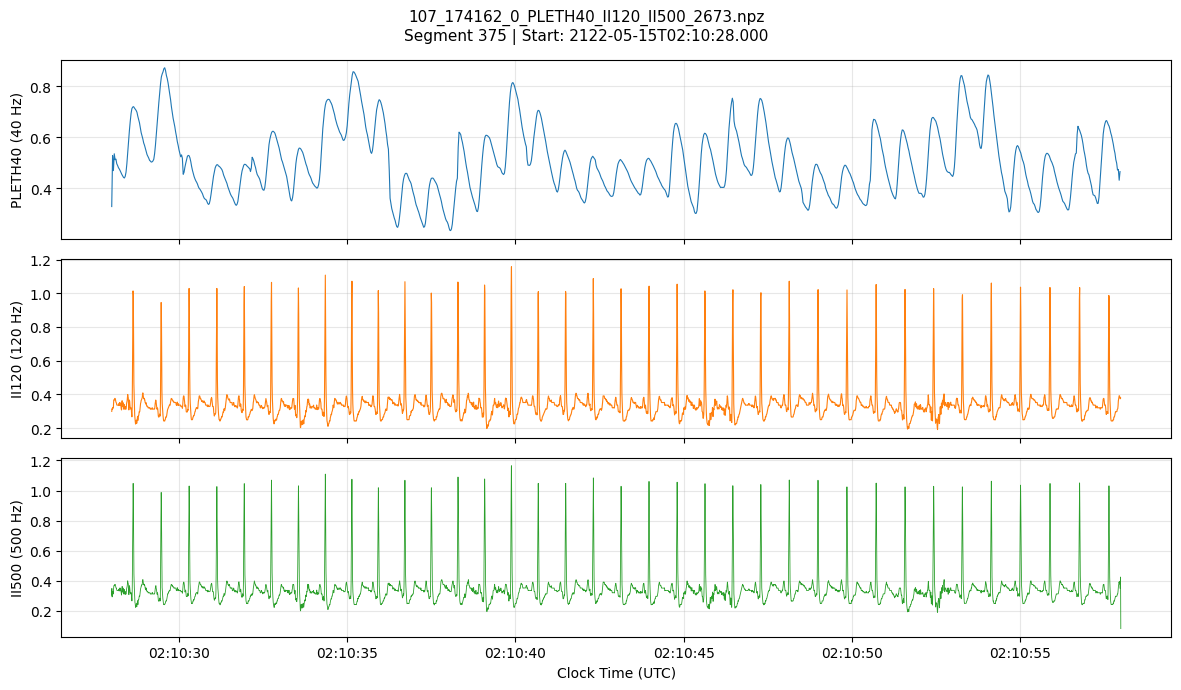

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ---------------------------------------------------------------------
# Configuration
DATA_DIR = "/opt/localdata100tb/UNIPHY_Plus/dataset/EST/MIMIC3_SPO2_I_40hz_v3_lab_vital"
print(len([f for f in os.listdir(DATA_DIR) if f.endswith(".npz")]))
FILE_NAME = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(".npz")])[0]
SEG_IDX = 375  # choose 30s segment to visualize

# Load npz
path = os.path.join(DATA_DIR, FILE_NAME)
data = np.load(path)

time_ms = data["time"]               # window start timestamps (ms)
pleth = data["PLETH40"]
ii120 = data["II120"]
ii500 = data["II500"]

print(f"Loaded {FILE_NAME}")
print(f"Segments: {pleth.shape[0]}")
print(f"PLETH40 length: {pleth.shape[1]}, II120 length: {ii120.shape[1]}, II500 length: {ii500.shape[1]}")



# Build REAL datetime x-axis for the 30s segment
# segment start timestamp in ms → Python datetime
start_dt = time_ms[SEG_IDX]

# durations
dt_pleth = [start_dt + timedelta(seconds=i/40)     for i in range(pleth.shape[1])]
dt_120   = [start_dt + timedelta(seconds=i/120)    for i in range(ii120.shape[1])]
dt_500   = [start_dt + timedelta(seconds=i/500)    for i in range(ii500.shape[1])]

# extract waveforms
pseg  = pleth[SEG_IDX]
e120s = ii120[SEG_IDX]
e500s = ii500[SEG_IDX]

# Plot with real datetime axis
fig, ax = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

ax[0].plot(dt_pleth, pseg, lw=0.8)
ax[0].set_ylabel("PLETH40 (40 Hz)")

ax[1].plot(dt_120, e120s, lw=0.8, color="tab:orange")
ax[1].set_ylabel("II120 (120 Hz)")

ax[2].plot(dt_500, e500s, lw=0.6, color="tab:green")
ax[2].set_ylabel("II500 (500 Hz)")
ax[2].set_xlabel("Clock Time (UTC)")

for a in ax:
    a.grid(True, alpha=0.3)

plt.suptitle(f"{FILE_NAME}\nSegment {SEG_IDX} | Start: {start_dt}", fontsize=11)
plt.tight_layout()
plt.show()


35


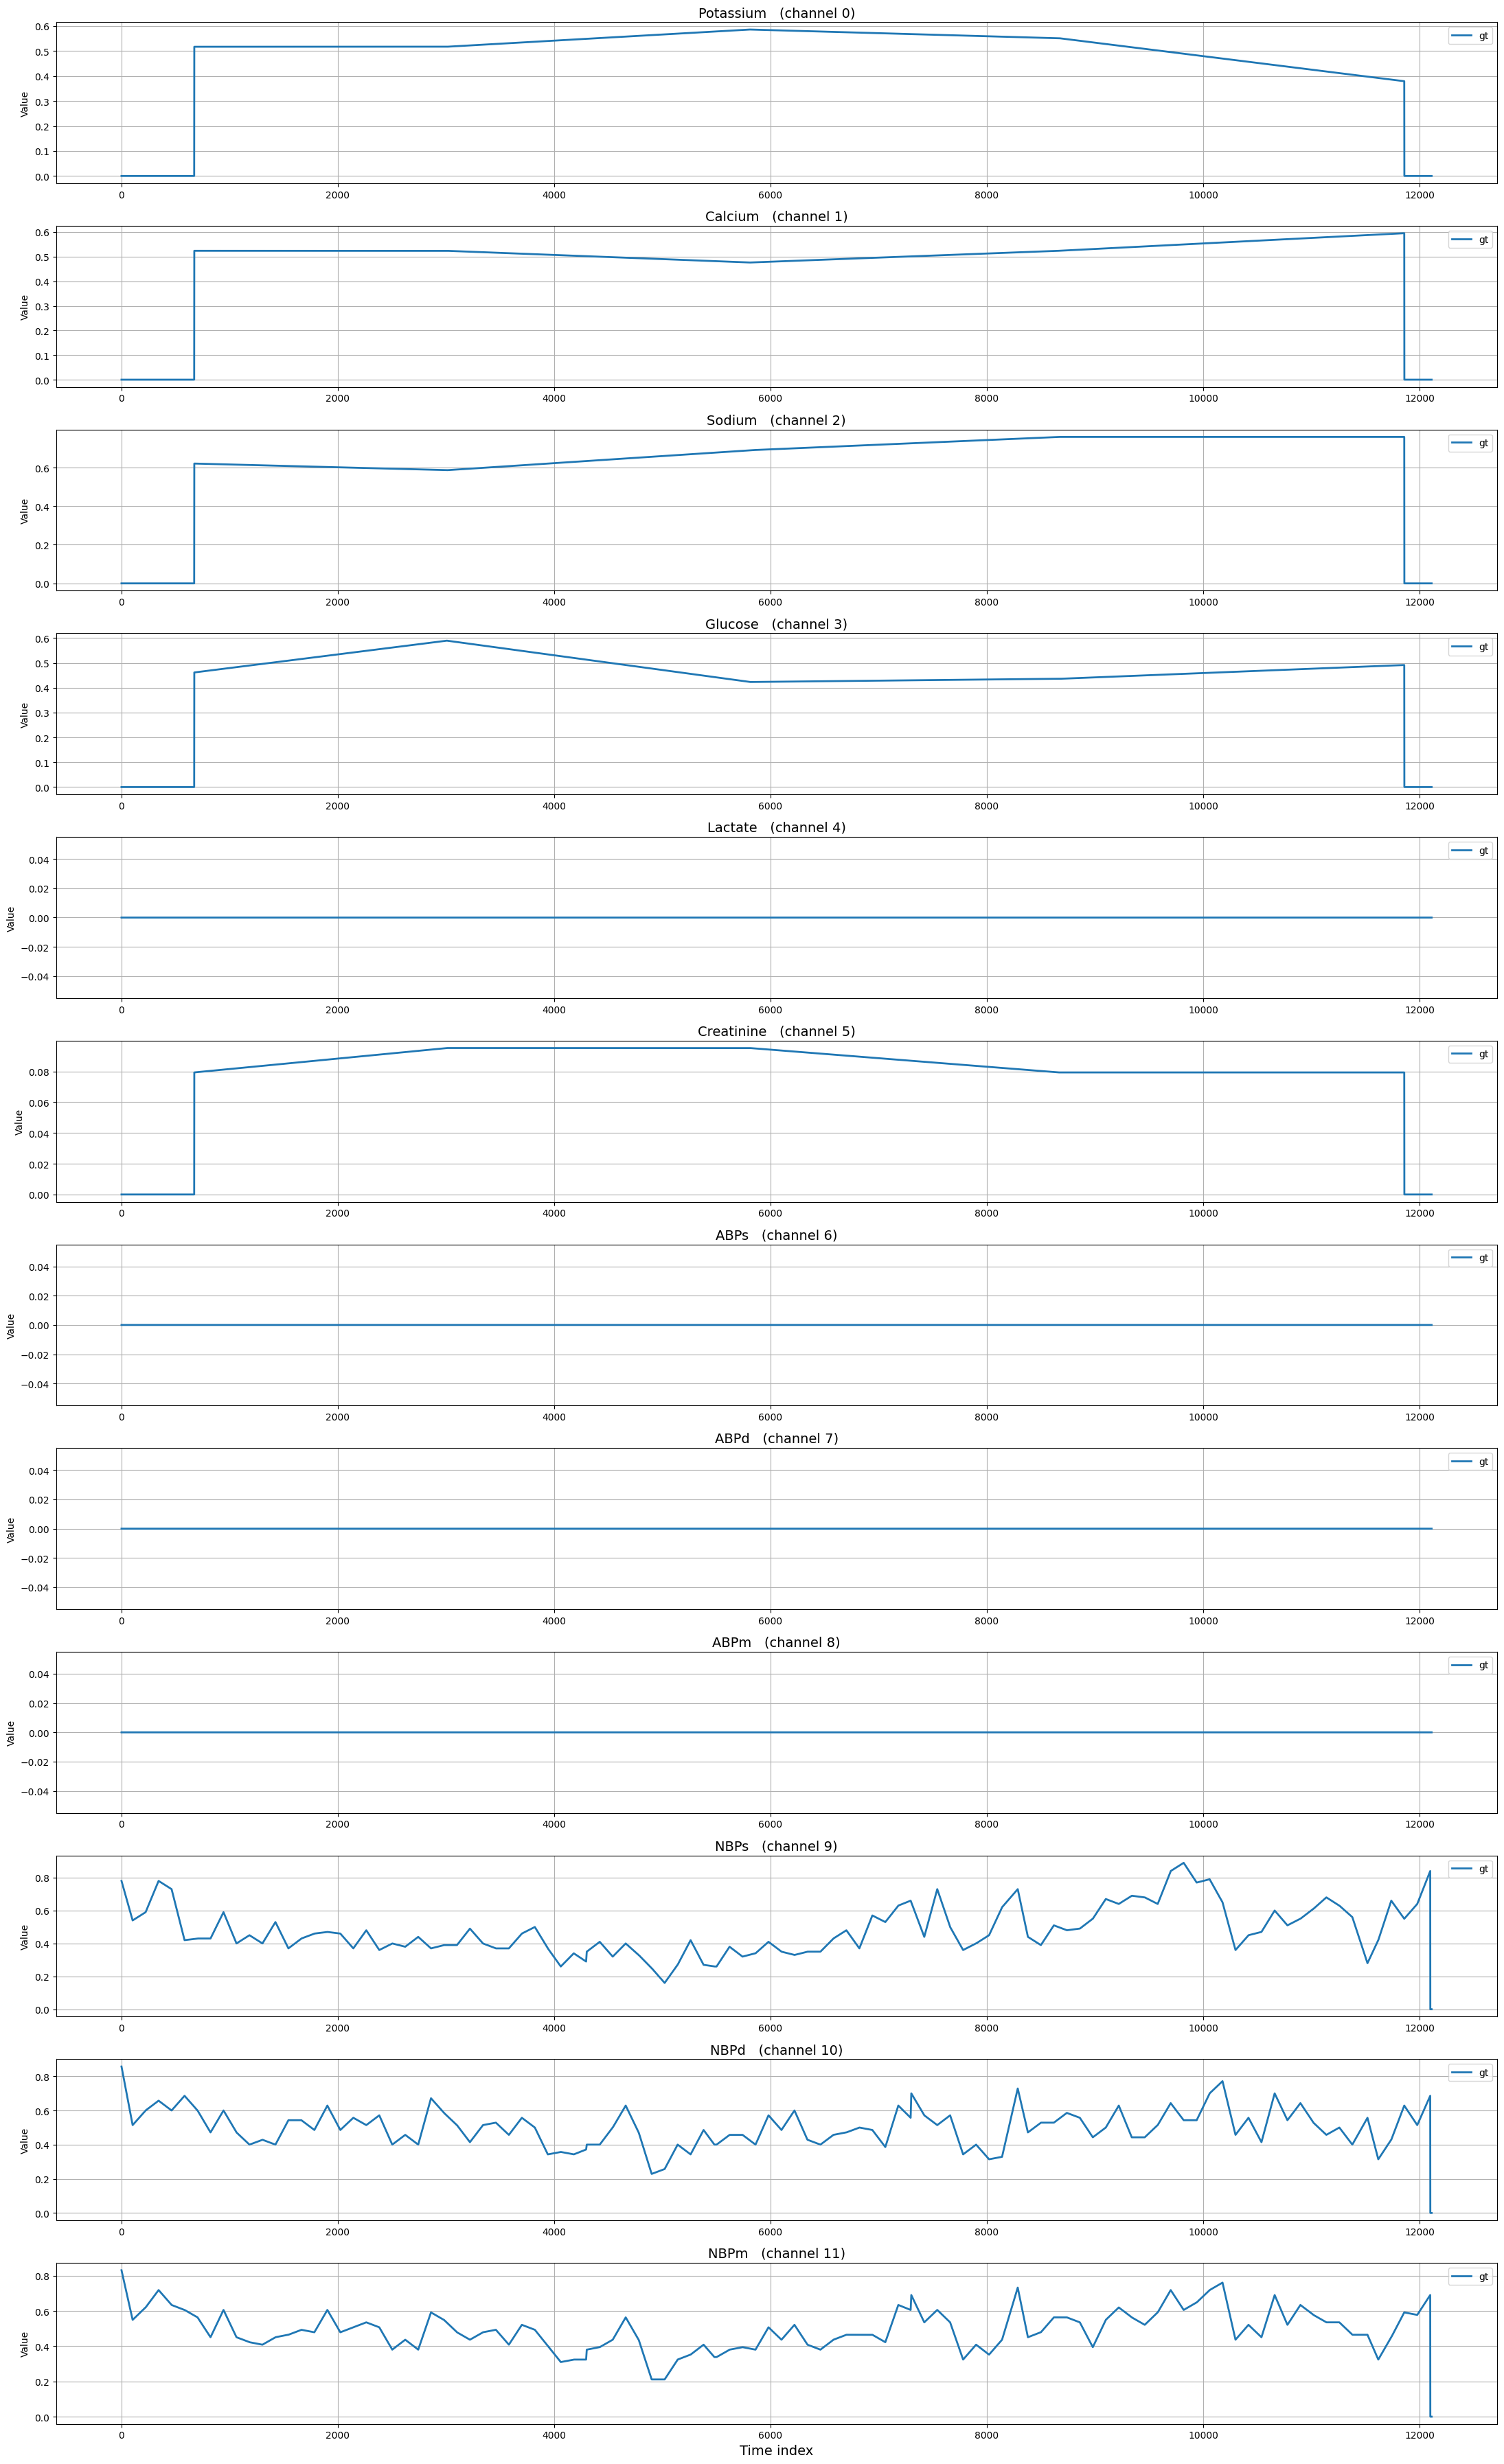

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ---------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------
DATA_DIR = "/opt/localdata100tb/UNIPHY_Plus/dataset/EST/MIMIC3_SPO2_I_40hz_v3_lab_vital"
print(len([f for f in os.listdir(DATA_DIR) if f.endswith(".npz")]))
FILE_NAME = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(".npz")])[5]
SEG_IDX = 375  # choose 30s segment to visualize

# ---------------------------------------------------------------------
# Load npz
# ---------------------------------------------------------------------
path = os.path.join(DATA_DIR, FILE_NAME)
data = np.load(path)

time_ms = data["time"]               # window start timestamps (ms)
pleth = data["PLETH40"]
ii120 = data["II120"]
ii500 = data["II500"]

# ---------------------------------------------------------------------
# Multi-channel EHR Plot along dim 0
# ---------------------------------------------------------------------

ehr_mask  = data["ehr_mask"]   # (T, C)
ehr_gt    = data["ehr_gt"]     # (T, C)
ehr_trend = data["ehr_trend"]  # (T, C)

T, C = ehr_gt.shape
time_axis = np.arange(T)

# Optional: give readable lab names
target_names = [
    "Potassium", "Calcium", "Sodium",
    "Glucose", "Lactate", "Creatinine",
        "ABPs", "ABPd", "ABPm",
    "NBPs", "NBPd", "NBPm",
]
if len(target_names) != C:
    target_names = [f"lab_{i}" for i in range(C)]

plt.figure(figsize=(22, 3*C))

for c in range(C):
    plt.subplot(C, 1, c+1)

    # Ground Truth
    plt.plot(time_axis, ehr_gt[:, c], label="gt", linewidth=2)

    # Trend
    #plt.plot(time_axis, ehr_trend[:, c], "--", linewidth=1.5, label="trend")

    # Mask (0/1/2)
    #plt.step(time_axis, ehr_mask[:, c], where="mid", label="mask", alpha=0.7)

    plt.title(f"{target_names[c]}   (channel {c})", fontsize=14)
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend(loc="upper right")

plt.xlabel("Time index", fontsize=14)
plt.tight_layout()
plt.show()
